In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from load_dataset import load_standardised_dataset
from image_standardisation import restore_standardised_image

In [2]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

2023-01-24 18:33:55.662323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 18:33:55.819036: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-24 18:33:55.819051: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-24 18:33:56.374296: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7

In [3]:
class BiggerDenoise(Model):
  def __init__(self):
    super(BiggerDenoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 3)),
      layers.Conv2D(16, (3, 3), activation='leaky_relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='leaky_relu', padding='same', strides=2),
      layers.Conv2D(4, (3, 3), activation='leaky_relu', padding='same', strides=2)])


    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(4, kernel_size=3, strides=2, activation='leaky_relu', padding='same'),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='leaky_relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='leaky_relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation="tanh", padding='same')
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [4]:
np.random.seed(256)
path_to_dataset = Path("../SIDD_Small_sliced/Data/")
TRAIN_PAIRS_TO_LOAD = 1000
TEST_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
VAL_PAIRS_TO_LOAD = TRAIN_PAIRS_TO_LOAD//8
train_x, train_y, test_x, test_y, val_x, val_y = load_standardised_dataset(str(path_to_dataset), TRAIN_PAIRS_TO_LOAD, TEST_PAIRS_TO_LOAD, VAL_PAIRS_TO_LOAD)

In [5]:
early = EarlyStopping(patience=3, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='loss', patience=2)

In [6]:
new_autoencoder = BiggerDenoise()
new_autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=["kullback_leibler_divergence", "MAE"])

2023-01-24 18:34:08.295689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-24 18:34:08.295813: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-24 18:34:08.295872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/garbarkozaurus/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-24 18:34:08.295922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loade

In [7]:
history = new_autoencoder.fit(train_x, train_y,
                epochs=10,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[early, reduce])

2023-01-24 18:34:08.478141: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.
2023-01-24 18:34:08.643579: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 786432000 exceeds 10% of free system memory.


Epoch 1/10
32/32 [==============================] - 34s 974ms/step - loss: 0.1192 - kullback_leibler_divergence: 2.1100 - MAE: 0.2984 - val_loss: 0.0695 - val_kullback_leibler_divergence: 2.3680 - val_MAE: 0.1996 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - 30s 947ms/step - loss: 0.0522 - kullback_leibler_divergence: 2.1088 - MAE: 0.1608 - val_loss: 0.0313 - val_kullback_leibler_divergence: 1.4653 - val_MAE: 0.1229 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - 31s 958ms/step - loss: 0.0173 - kullback_leibler_divergence: 0.3470 - MAE: 0.0914 - val_loss: 0.0111 - val_kullback_leibler_divergence: 0.1767 - val_MAE: 0.0737 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - 30s 949ms/step - loss: 0.0113 - kullback_leibler_divergence: 0.1546 - MAE: 0.0725 - val_loss: 0.0096 - val_kullback_leibler_divergence: 0.1318 - val_MAE: 0.0671 - lr: 0.0010
Epoch 5/10
32/32 [==============================] - 30s 931ms/step - loss: 0.0104 - kullback_lei

In [9]:
new_autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 4)         292       
                                                                 
Total params: 1,900
Trainable params: 1,900
Non-trainable params: 0
_________________________________________________________________


In [10]:
new_autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 4)         292       
                                                                 
Total params: 1,900
Trainable params: 1,900
Non-trainable params: 0
_________________________________________________________________


In [12]:
new_autoencoder.evaluate(test_x, test_y)

4/4 [==============================] - 1s 312ms/step - loss: 0.0077 - kullback_leibler_divergence: 0.0950 - MAE: 0.0595


[0.007699079345911741, 0.0949808657169342, 0.05947120115160942]

In [13]:
new_autoencoder.encoder.save("new_encoder.h5")
new_autoencoder.decoder.save("new_decoder.h5")

In [15]:
encoded_imgs = new_autoencoder.encoder(test_x).numpy()
decoded_imgs = new_autoencoder.decoder(encoded_imgs).numpy()

2023-01-24 18:43:00.576680: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 524288000 exceeds 10% of free system memory.
2023-01-24 18:43:01.080965: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 524288000 exceeds 10% of free system memory.
2023-01-24 18:43:01.202932: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 524288000 exceeds 10% of free system memory.


In [16]:
rgb_decoded_imgs = np.array([restore_standardised_image(img) for img in decoded_imgs])

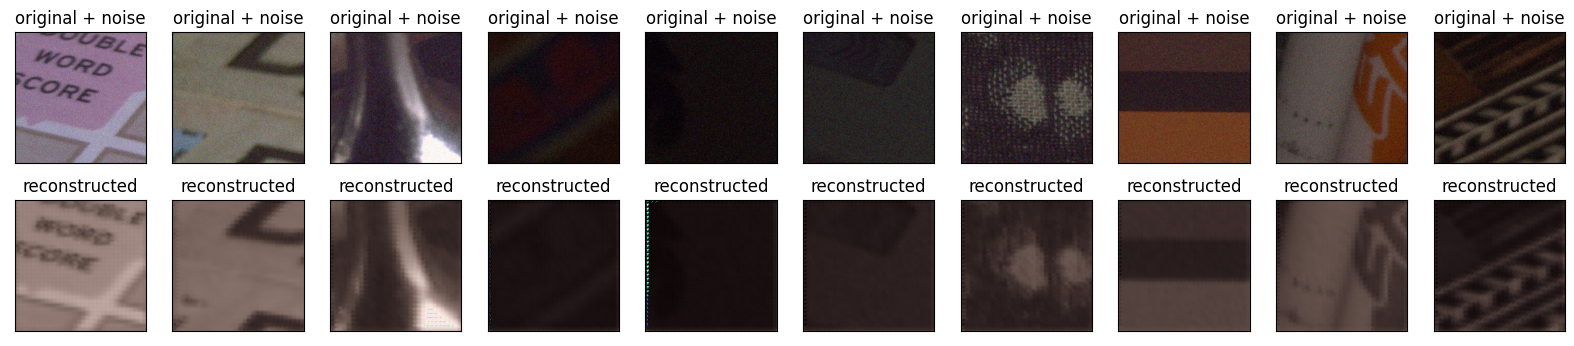

In [17]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(restore_standardised_image(test_x[i])))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(rgb_decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

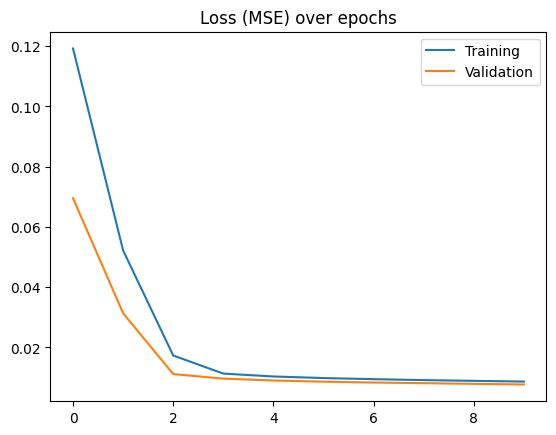

In [18]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.title("Loss (MSE) over epochs")
plt.show()

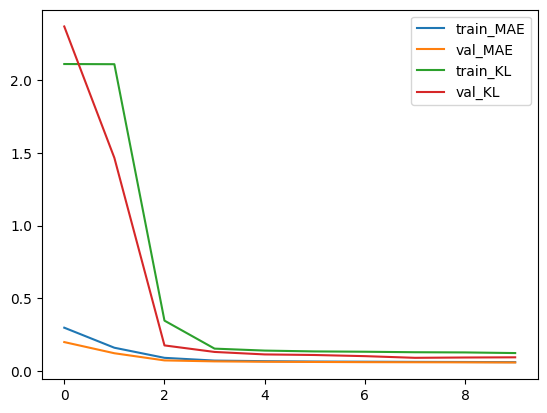

In [19]:
plt.plot(history.history["MAE"])
plt.plot(history.history["val_MAE"])
plt.plot(history.history["kullback_leibler_divergence"])
plt.plot(history.history["val_kullback_leibler_divergence"])
plt.legend(["train_MAE", "val_MAE", "train_KL", "val_KL"])
plt.show()

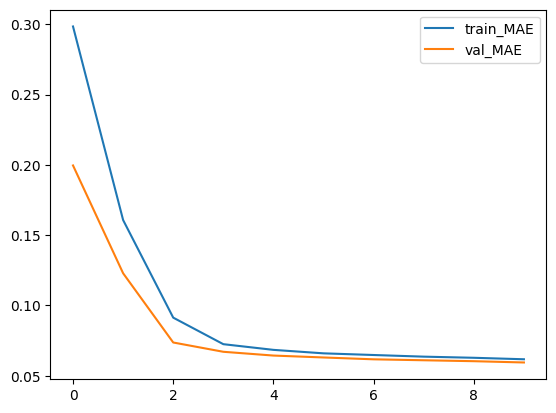

In [20]:
plt.plot(history.history["MAE"])
plt.plot(history.history["val_MAE"])
plt.legend(["train_MAE", "val_MAE"])
plt.show()